In [1]:
from dataclasses import dataclass
from typing import Dict

import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import ogbench
from bnn_pref.utils.type import Q1, Q2TD
from bnn_pref.utils.utils import get_random_seed

seed = get_random_seed()
key = jr.key(seed)
key, key1, key2 = jr.split(key, 3)

# task_name = "antmaze-medium-navigate-singletask-v0"
task_name = "pointmaze-medium-navigate-singletask-v0"
env, train_trajs, val_trajs = ogbench.make_env_and_datasets(
    task_name,
    compact_dataset=False,
    render_mode="rgb_array",
)


def process_ogbench(ds: Dict[str, np.ndarray]) -> Dict[str, jnp.ndarray]:
    """
    transform dataset dictionary:
    observations (5000000, 29) -> (10000, 500, 29)
    actions (5000000, 8) -> (10000, 500, 8)
    terminals (5000000,) -> (10000, 500)
    next_observations (5000000, 29) -> (10000, 500, 29)
    rewards (5000000,) -> (10000, 500)
        new field: returns (10000, 500) -> (10000,)
    masks (5000000,) -> (10000, 500)

    Returns only obs, actions, returns

    Number of trajectories: 10000
    """
    # seperate trajectories via terminals field
    starts = jnp.where(ds["terminals"])[0]
    ends = jnp.concatenate([jnp.array([-1]), starts[:-1]])
    ds = jax.tree.map(
        lambda x: jnp.array([x[s + 1 : e + 1] for s, e in zip(ends, starts)]),
        ds,
    )

    # thin out trajectories
    thin_rate = 3
    ds = jax.tree.map(lambda x: x[:, ::thin_rate], ds)

    # sum rewards to get returns, keep only obs, actions, returns
    ds["returns"] = ds["rewards"].sum(axis=-1)
    # ds = {k: ds[k] for k in ["observations", "actions", "returns"]}

    # filter out low return trajectories
    n_traj, traj_len, _ = ds["observations"].shape
    ds = jax.tree.map(lambda x: x[ds["returns"] > -traj_len], ds)

    # sort trajectories by return (ascending)
    sorted_idxes = jnp.argsort(ds["returns"])
    ds = jax.tree.map(lambda x: x[sorted_idxes], ds)

    return ds


for k, v in train_trajs.items():
    print(f"{k}: {v.shape}")
print()
train_trajs = process_ogbench(train_trajs)
val_trajs = process_ogbench(val_trajs)
for k, v in train_trajs.items():
    print(f"{k}: {v.shape}")


observations: (1000000, 2)
actions: (1000000, 2)
terminals: (1000000,)
next_observations: (1000000, 2)
rewards: (1000000,)
masks: (1000000,)

actions: (248, 334, 2)
masks: (248, 334)
next_observations: (248, 334, 2)
observations: (248, 334, 2)
returns: (248,)
rewards: (248, 334)
terminals: (248, 334)


(248, 334)


(array([232.,   8.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,   2.]),
 array([-333., -309., -285., -261., -237., -213., -189., -165., -141.,
        -117.,  -93.]),
 <BarContainer object of 10 artists>)

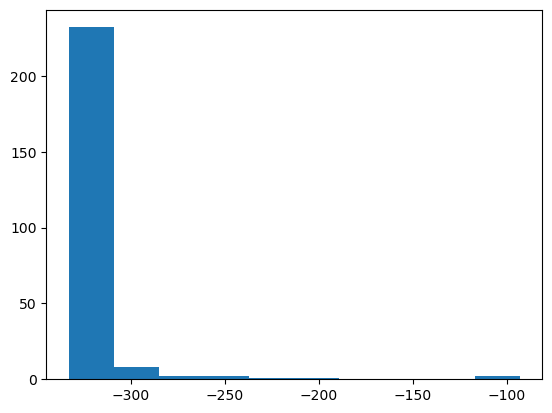

In [2]:
print(train_trajs["rewards"].shape)
plt.hist(train_trajs["returns"])

In [3]:
print(train_trajs["observations"].shape)
print(train_trajs["observations"].min(axis=(0, 1)))
print(train_trajs["observations"].max(axis=(0, 1)))

print()
print(val_trajs["observations"].shape)
print(val_trajs["observations"].min(axis=(0, 1)))
print(val_trajs["observations"].max(axis=(0, 1)))


(248, 334, 2)
[-0.9974886 -0.9922606]
[20.98673  21.184114]

(22, 334, 2)
[-0.7479793  -0.60424984]
[20.9037   20.916208]


traj_idx=178
[8.754044 8.900924]


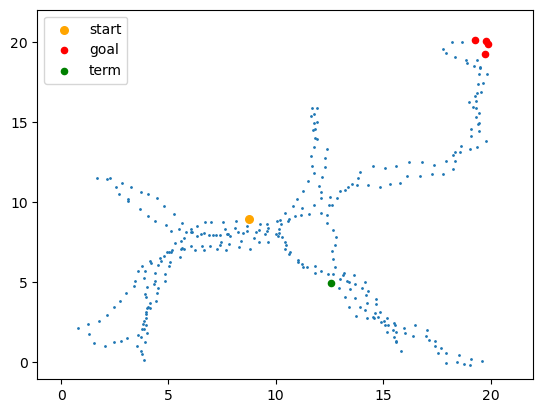

In [30]:
num_trajs = len(train_trajs["returns"])
traj_idx = np.random.randint(0, num_trajs)
# traj_idx = -11
print(f"{traj_idx=}")

traj = jax.tree.map(lambda x: x[traj_idx], train_trajs)
obs = traj["observations"]
goal_idxes = jnp.where(traj["rewards"] == 0)[0]
term_idxes = jnp.where(traj["terminals"])[0]


print(obs[0])
plt.scatter(obs[:, 0], obs[:, 1], s=1)
plt.scatter(obs[0, 0], obs[0, 1], color="orange", s=30, label="start")
plt.scatter(obs[goal_idxes, 0], obs[goal_idxes, 1], color="red", s=20, label="goal")
plt.scatter(obs[term_idxes, 0], obs[term_idxes, 1], color="green", s=20, label="term")
plt.xlim(-1.1, 22)
plt.ylim(-1.1, 22)
plt.legend()


(248, 334, 2)
(248, 334)
(82832, 2)
(248, 2)
(1962, 2)


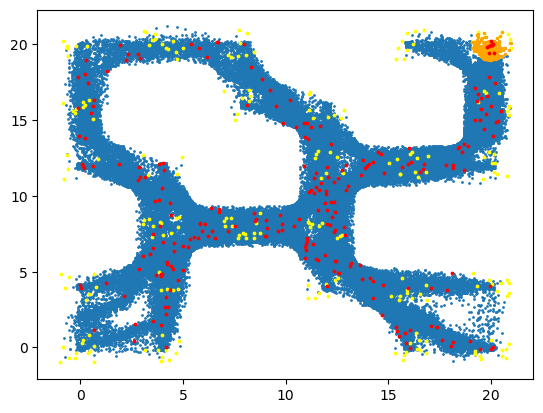

In [31]:
print(train_trajs["observations"].shape)  # N, T, D
print(train_trajs["rewards"].shape)  # N, T

all_obs = train_trajs["observations"].reshape(-1, 2)  # N*T, D
print(all_obs.shape)

all_starts = train_trajs["observations"][:, 0, :]  # N, D
print(all_starts.shape)

all_ends = train_trajs["observations"][:, -1, :]  # N, D


xx, yy = jnp.where(train_trajs["rewards"] == 0)
all_goals = train_trajs["observations"][xx, yy, :]
print(all_goals.shape)


plt.scatter(all_obs[:, 0], all_obs[:, 1], s=1)
plt.scatter(all_starts[:, 0], all_starts[:, 1], color="yellow", s=3, label="start")
plt.scatter(all_goals[:, 0], all_goals[:, 1], color="orange", s=2, label="end")
plt.scatter(all_ends[:, 0], all_ends[:, 1], color="red", s=3, label="goal")